# Introduction

***Please, pay attention, that it shows the logic of training the model, but it doesn't include all needed pieces of code which is necessary to run it from top to bottom and reproduce the result.***

Usually, a text is not just a set of symbols. The symbols have a particular structure.

In order to get a text from the symbols we need to get their correct order on the page (the image). We're going to collect symbols into lines.

In [ ]:
# configurate ipython widgets

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [ ]:
# connect to Google Colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set a path to the provided code

repo_folder = '/content/drive/MyDrive/github/'

In [ ]:
# install requirements

reqs_path = repo_folder + 'IntelligentDocumentProcessing/requirements.txt '
!pip3 install -r {reqs_path}

In [ ]:
# connect to W&B

import wandb
wandb_key = open('/content/drive/MyDrive/ssh/wandbkey.txt').read()
wandb.login(key=wandb_key)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
# add a path to utils

import sys
base_folder = repo_folder + 'Resources/'
sys.path.append(base_folder)
sys.path.append(repo_folder + 'Resources/')
sys.path.append(repo_folder)

# Data

## Augmentations for the data

As usual, augmentations are needed to increase a model's robustness.

In [ ]:
import albumentations as A
import cv2

transform = A.Compose([
    A.Perspective(p=0.7),
    A.OpticalDistortion(p=0.7, distort_limit=0.1, shift_limit=0.2,
                        border_mode=cv2.BORDER_CONSTANT, value=0),
    A.ShiftScaleRotate(rotate_limit=10, shift_limit=0, p=0.7,
                       border_mode=cv2.BORDER_CONSTANT, value=0),
])

## Visual analysis of images

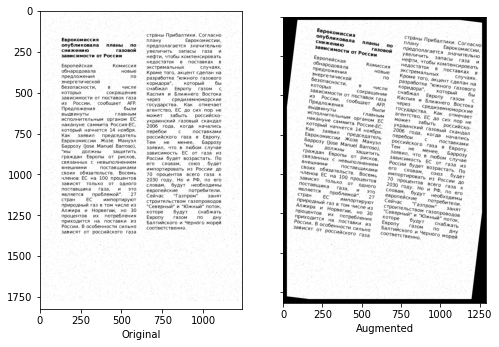

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

image_dir = '/content/drive/MyDrive/data/la_data/c_Layout_Analisys_data/'
image_fpaths = Path(image_dir).glob("*.jpg")

for fpath in list(image_fpaths)[:1]:
    original_image = cv2.imread(str(fpath))
    original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    image = transform(image=original_image)['image']
    h, w, _ = image.shape
    # Add a small padding in order to keep the lines inside the image
    pad_transform = A.PadIfNeeded(min_height=h+50, min_width=w+50, border_mode=cv2.BORDER_CONSTANT, value=0)
    image = pad_transform(image=image)['image']

    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,12))
    ax1.set_xlabel('Original')
    ax2.set_xlabel('Augmented')
    ax1.imshow(original_image)
    ax2.imshow(image)
    plt.show()

# Inference of lines

## Line detection

The inference of the line detector coincides with the inference of the text detector. But there is the only difference. We need to normalize all bounding boxes by the height/width of an image in order to limit all coordinates by 0 and 1.

In [ ]:
from typing import Union, List

import torch.nn as nn
import numpy as np
from albumentations import BasicTransform, Compose, OneOf
from albumentations.pytorch import ToTensorV2

from c_Layout_Analisys.utils import Line
from a_Text_Detection.utils import DrawMore, Postprocessor

import torch

def line_detector_inference(
    model: nn.Module,
    image: np.ndarray,
    transform: Union[BasicTransform, Compose, OneOf],
    postprocessor: Postprocessor,
    device: str = 'cpu',
) -> List[Line]:
    # image preprocessing
    h, w, _ = image.shape
    image_changed = transform(image=image)['image']
    image_changed = torch.Tensor(image_changed[np.newaxis,:])
    # making predictions
    with torch.no_grad():
        prediction = model(image_changed.to(device))
    # postprocessing
    pred_image = prediction[0].cpu().detach().numpy()
    bboxs = postprocessor(w, h, pred_image, return_polygon=False)[0][0]
    # нормализация bounding box'ов по высоте и ширине
    bboxs_arrays = np.array([np.array(x) for x in bboxs])
    normalized_bboxs=bboxs_arrays/np.array([w, h])
    # create a list of objects of type 'Line'
    res = [Line(bbox=x, normalized_bbox=y) for x, y in zip(bboxs_arrays, normalized_bboxs)]

    return res


size = 512
transform = A.Compose([

    A.PadIfNeeded(
        min_height=size,
        min_width=size,
        border_mode=cv2.BORDER_CONSTANT,
        value=0,
        mask_value=None,
        always_apply=False,
        p=1.0,
    ),
    A.Normalize(
        mean=[0, 0, 0],
        std=[1, 1, 1],
        max_pixel_value=255.,
        p=1.,
    ),
    ToTensorV2(p=1.)
])
postprocessor = Postprocessor(
    unclip_ratio=1.5,
    binarization_threshold=0.3,
    confidence_threshold=0.7,
    min_area=1,
    max_number=1000
)

In [ ]:
import torch

from c_Layout_Analisys.utils import resize_aspect_ratio


max_image_size = 2048
device='cpu'
line_model_path = '/content/drive/MyDrive/data/la_data/la.jit'
line_model = torch.jit.load(line_model_path, map_location=device)
line_model.eval();

image, _, _ = resize_aspect_ratio(image, square_size=max_image_size, interpolation=cv2.INTER_LINEAR)
image = image.astype(np.uint8)
lines = line_detector_inference(line_model, image, transform, postprocessor, device)

Let's look at the result:

[[ 706.  595.]
 [1211.  657.]
 [1205.  708.]
 [ 700.  646.]]


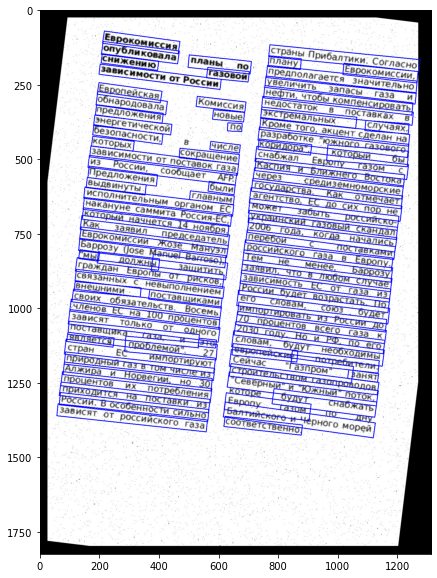

In [ ]:
vis_result = image.copy()

for i, line in enumerate(lines):
    DrawMore.draw_contours(vis_result, [line.bbox], thickness=2, inplace=True, color=(0, 0, 255))
    if i == 10:
      print(line.bbox)

plt.figure(figsize=(10, 10))
plt.imshow(vis_result)
plt.show()

# Collect lines into paragraphs

We're comparing each two lines by three metrics:

- **parallelness** describes how parallel lines in a paragraph are. Lines are parallel if $\angle(l_1, l_2) \leq \theta$ (the angle belongs to the interval [-90, 90])
- **distance** is a distance between two lines (according to Euclidian distance between two first points of normalized bounding boxes)
- **overlap** is overlapping of the lines

The algorithm of collection lines into paragraphs includes the following steps:

1. Clusterization of input lines with the help of the `DBSCAN` algorithm
2. Finding a bounding box for the paragraph
3. Sorting lines inside the paragraph and paragraphs inside the page

In [ ]:
import math

from sklearn.cluster import DBSCAN

from c_Layout_Analisys.utils import sort_boxes_top2down_wrt_left2right_order, sort_boxes, fit_bbox, Paragraph


def angle_of_vectors(a,b,c,d):

    dotProduct = a @ c[np.newaxis].T + b @ d[np.newaxis].T
    print(dotProduct)
    # for three dimensional simply add dotProduct = a*c + b*d  + e*f
    modOfVector1 = math.sqrt(a @ a[np.newaxis].T + b @ b[np.newaxis].T)*math.sqrt(c @ c[np.newaxis].T + d @ d[np.newaxis].T)
    # for three dimensional simply add modOfVector = math.sqrt( a*a + b*b + e*e)*math.sqrt(c*c + d*d +f*f)
    angle = dotProduct/modOfVector1
    print("Cosθ =",angle)
    angleInDegree = math.degrees(math.acos(angle))
    print("θ =",angleInDegree,"°")


class ParagraphFinder:
    def __init__(
        self,
        angle_threshold: int = 10,
        overlapping_threshold: float = 0.3,
        max_distance: int = 1,
        cluster_eps: float = 0.5
    ):
        self.angle_threshold = angle_threshold
        self.overlapping_threshold = overlapping_threshold
        self.max_distance = max_distance
        self.cluster_eps = cluster_eps

    @staticmethod
    def _distance(line1: Line, line2: Line) -> float:
        (x11, y11), (x12, y12), _, _ = line1.normalized_bbox
        (x21, y21), (x22, y22), _, _ = line2.normalized_bbox
        y1m = (y12 + y11) / 2
        y2m = (y22 + y21) / 2
        return abs(y1m - y2m)

    @staticmethod
    def _length(line: Line) -> float:
        return np.linalg.norm(line.normalized_bbox[0] - line.normalized_bbox[1])

    def _overlapping(self, line1: Line, line2: Line) -> float:
        (x11, y11), (x12, y12), _, _ = line1.normalized_bbox
        (x21, y21), (x22, y22), _, _ = line2.normalized_bbox
        x_min = max(x11, x21)
        x_max = min(x12, x22)

        if x_max - x_min < 0:
          return 0

        return (x_max - x_min) / self._length(line1)


    @staticmethod
    def _angle(line1: Line, line2: Line) -> float:
        (x11, y11), (x12, y12), _, _ = line1.normalized_bbox
        (x21, y21), (x22, y22), _, _ = line2.normalized_bbox
        d_x1 = x12 - x11
        d_y1 = y12 - y11
        d_x2 = x22 - x21
        d_y2 = y22 - y21

        theta = math.atan(d_y2/d_x2) - math.atan(d_y1/d_x1)
        theta = math.degrees(theta)

        if theta > 90:
          theta -= 180
        if theta < -90:
          theta += 180

        return theta

    def paragraph_distance(self, line1: np.ndarray, line2: np.ndarray) -> float:
        line1 = Line(normalized_bbox=line1.reshape(4, 2))
        line2 = Line(normalized_bbox=line2.reshape(4, 2))

        if abs(self._angle(line1, line2)) > self.angle_threshold:
            return self.max_distance

        if self._overlapping(line1, line2) < self.overlapping_threshold:
            return self.max_distance

        return self._distance(line1, line2)

    @staticmethod
    def prepare_lines(lines: List[Line]) -> np.ndarray:
        return np.array([line.normalized_bbox.reshape(-1) for line in lines])

    def fit_cluster(self, lines: List[Line]) -> DBSCAN:
        prepared_lines = self.prepare_lines(lines)
        cluster = DBSCAN(metric=self.paragraph_distance, eps=self.cluster_eps)
        cluster.fit(prepared_lines)
        return cluster

    @staticmethod
    def sort_paragraphs(paragraphs):
        for par in paragraphs:
            par.items = sort_boxes(par.items, sorting_type = 'top2down')  # sorting from top to down
        paragraphs = sort_boxes_top2down_wrt_left2right_order(paragraphs)  # sorting in order of reading
        return paragraphs

    def find_paragraphs(self, lines: List[Line]) -> List[Paragraph]:
        cluster = self.fit_cluster(lines)

        paragraphs = []
        print(set(cluster.labels_))
        for label in set(cluster.labels_):
            line_indexes = np.argwhere(cluster.labels_ == label)
            par_lines = [lines[idx[0]] for idx in line_indexes]
            bbox = fit_bbox(np.array([lines[idx[0]].bbox for idx in line_indexes]))
            par = Paragraph(items=par_lines, bbox=bbox)
            paragraphs.append(par)
        paragraphs = self.sort_paragraphs(paragraphs)
        return paragraphs

The method can work much better in the case of selecting correct values for the following parameters: `angle_threreshold`, `max_distance`, `overlapping_threshold`, and `cluster_eps`. In this notebook, the step is skipped but you can play with their values (and make sure that it's important) below.

# Result visualization

In [ ]:
# chosen parameters

overlapping_threshold = 0.5
cluster_eps = 0.3

{0, 1, 2, 3, 4, 5}


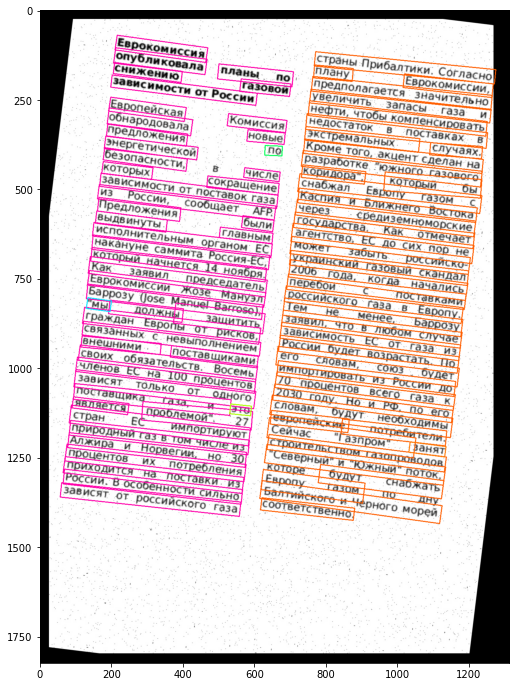

In [ ]:
from c_Layout_Analisys.utils import get_random_color, draw_paragraphs

paragraph_finder = ParagraphFinder(overlapping_threshold=overlapping_threshold, cluster_eps=cluster_eps)
paragraphs = paragraph_finder.find_paragraphs(lines)
draw_paragraphs(image, paragraphs)

In [ ]:
# interactive changing the parameters

from ipywidgets import interact, IntSlider, FloatSlider, fixed

def wrapper(image, lines, angle_threshold=10, overlapping_threshold=0.3, cluster_eps=0.5):
    paragraph_finder = ParagraphFinder(angle_threshold, overlapping_threshold, 1, cluster_eps)
    paragraphs = paragraph_finder.find_paragraphs(lines)
    print('Количество параграфов:', len(paragraphs))
    draw_paragraphs(image, paragraphs)

interact(
    wrapper,
    image=fixed(image),
    lines=fixed(lines),
    angle_threshold=IntSlider(min=0, max=50, step=5, value=10),
    overlapping_threshold=FloatSlider(min=0, max=1, step=0.05, value=0.3),
    cluster_eps=FloatSlider(min=0.01, max=1.5, step=0.05, value=0.5)
);

interactive(children=(IntSlider(value=10, description='angle_threshold', max=50, step=5), FloatSlider(value=0.…

In order to be sure that we collected the lines into the right order, let's add numeration to the image.

In [ ]:
import random

def draw_paragraphs_with_line_idx(image: np.ndarray, paragraphs: List[Paragraph]) -> None:
    for paragraph in paragraphs:
        color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        for i, line in enumerate(paragraph.items):
            DrawMore.draw_contours(image, [line.bbox], color=color, thickness=2, inplace=True)
            cv2.putText(image, str(i), tuple(line.bbox[1].astype(int)), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    plt.figure(figsize=(10, 12))
    plt.imshow(image)

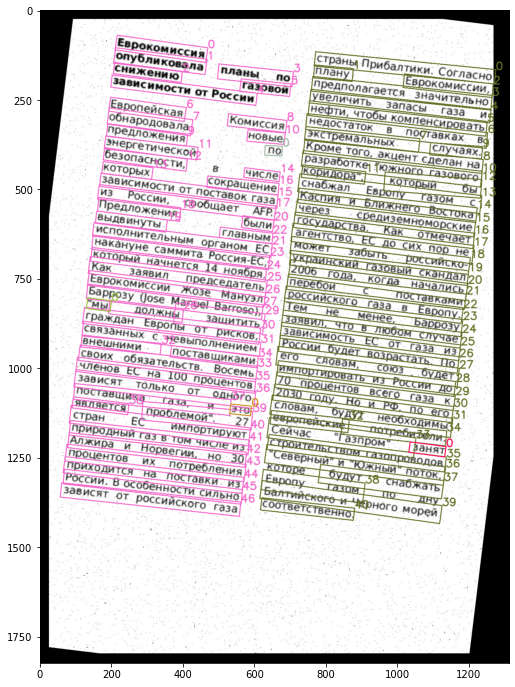

In [ ]:
draw_paragraphs_with_line_idx(image, paragraphs)